The fitting may need to be done several times to find the best range of the parameters. After these adjustments, all parameters have few outliers. And it is possible to use np.interp to interpolate some of the parameter-vs-E curves.

In [71]:
cd ~/dv/PyChop/SNS/

/SNS/users/lj7/dv/mantid/mantid/scripts/PyChop/SNS


# Tools

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import histogram.hdf as hh, histogram as H
import lmfit

In [3]:
from dgsres import icg

# Fit

In [4]:
from dgsres.powder import fit

In [19]:
params = lmfit.Parameters()
# at first the max was 1.0. after trying it, it seems better to set max to 0.6 because points outside the range look like outliers
params.add('a', min=0., max=0.4)
# at first the max was 0.5. 
params.add('b', min=0., max=.12)
params.add('R', value=0.5, min=0.35, max=0.7)
params.add('sigma', min=0., max=20.)
params.add('t0', min=0., max=100.)

Ei = 100.
geom = icg.Geom(l1=11.6, l2=2.0, l3=3.)

fitIE = fit.Fit_IE(
    simout="/SNS/users/lj7/dv/PyChop/SNS/mcvine-res-Ei_100/out/",
    Ei=Ei,
    params = params,
    geom = geom,
)
Q = 5.6

In [20]:
%%time
results = {}
for E0 in np.arange(-90., Ei-1, 10.):
    print E0
    results[E0] = fitIE.fit(Q=Q, E=E0)
    continue

-90.0
-80.0
-70.0
-60.0
-50.0
-40.0
-30.0
-20.0
-10.0
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
CPU times: user 1min 23s, sys: 132 ms, total: 1min 23s
Wall time: 1min 23s


<IPython.core.display.Javascript object>


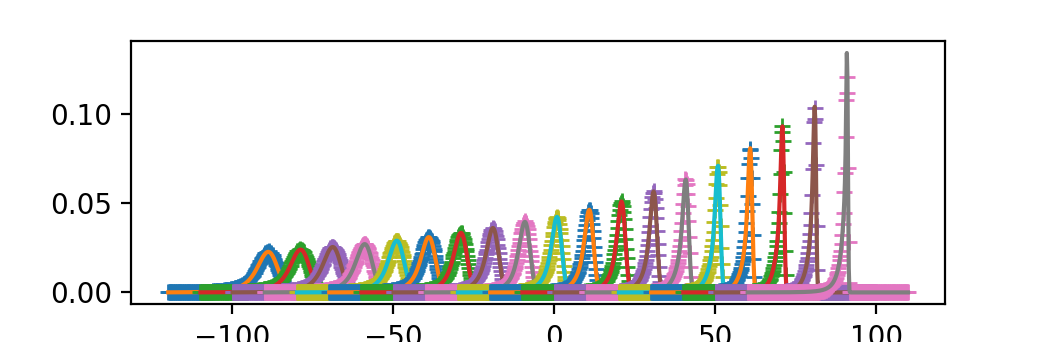

In [69]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(-90., Ei-1, 10.):
    x,y0,y0err = fitIE.getData(Q, E0)
    y = icg.resolution(x, Ei=Ei, E0=E0, geom=geom, **results[E0].params.valuesdict())
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x,y0, '+')
    plt.plot(x, y)
plt.show()

In [22]:
E0s = np.arange(-90., Ei-1, 10.)
def get_p_list(name):
    return [results[E0].params[name].value for E0 in E0s]

The plot generated by the following cell can clearly show how many outliers exist for parameters. Try to minimize the number of outliers by changing the parameters (up in the `fitting parameters` section) and execute all the cells in between that cell and the next cell

In [ ]:
variables = 't0 sigma a b R'.split()
plt.figure(figsize=(6,8))
for i,v in enumerate(variables):
    plt.subplot(3, 2, i+1)
    plt.plot(E0s, get_p_list(v), '-o', label=v)
    plt.legend()
    continue

plt.subplot(3, 2, 6)
plt.plot(E0s, E0s, '-o', label='E')
plt.legend()

plt.tight_layout()
plt.show()

# Interpolate

## a

In [ ]:
plt.figure()
x = E0s
y = np.array(get_p_list('a'))
plt.plot(x, y, '+')

There is one outlier. Here for simplicity we remove two points

In [25]:
good = y < .39
xgood = x[good]; ygood = y[good]

In [ ]:
plt.figure()
plt.plot(xgood, ygood)

In [27]:
a2, a1, a0 = np.polyfit(xgood, ygood, 2)

In [ ]:
plt.figure()
plt.plot(x,y)
plt.plot(E0s, a0+a1*E0s+a2*E0s**2)

In [29]:
a0_a = a0; a1_a = a1; a2_a = a2

## b

In [ ]:
plt.figure()
x = E0s
y = np.array(get_p_list('b'))
plt.plot(x, y, '+')

In [59]:
a2, a1, a0 = np.polyfit(x, y, 2)

In [ ]:
plt.figure()
plt.plot(x,y)
plt.plot(E0s, a0+a1*E0s+a2*E0s**2)

In [61]:
a0_b = a0; a1_b = a1; a2_b = a2

## R

In [ ]:
plt.figure()
x = E0s
y = np.array(get_p_list('R'))
plt.plot(x, y, '+')

In [41]:
a2, a1, a0 = np.polyfit(x, y, 2)

In [ ]:
plt.figure()
plt.plot(x,y)
plt.plot(E0s, a0+a1*E0s+a2*E0s**2)

In [43]:
a0_R = a0; a1_R = a1; a2_R = a2

## t0
a and b are easy to fit. But t0 and sigma are harder to fit. We just do a simple interpolation

In [ ]:
plt.figure()
plt.plot(E0s, get_p_list('t0'), '+')

There is no outlier

In [34]:
x_t0 = E0s.copy(); y_t0 = np.array(get_p_list('t0'))

## sigma

In [ ]:
plt.figure()
plt.plot(E0s, get_p_list('sigma'), '+')

There is no outlier

In [36]:
# mask = E0s < 118.
x_sigma = E0s.copy(); y_sigma = np.array(get_p_list('sigma'))

# Save parameters

In [37]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [72]:
pwd

u'/SNS/users/lj7/dv/mantid/mantid/scripts/PyChop/SNS'

In [73]:
%%writetemplate res_params_interped_funcs_Ei_100.py
import numpy as np
def parabolic(a0, a1, a2):
    return lambda E: a0 + a1*E + a2*E*E

a0_a = {a0_a}
a1_a = {a1_a}
a2_a = {a2_a}
a0_b = {a0_b}
a1_b = {a1_b}
a2_b = {a2_b}
a0_R = {a0_R}
a1_R = {a1_R}
a2_R = {a2_R}
from numpy import array
x_t0 = {x_t0!r}
y_t0 = {y_t0!r}
x_sigma = {x_sigma!r}
y_sigma = {y_sigma!r}

interped_funcs = dict(
    a = parabolic(a0_a, a1_a, a2_a),
    b = parabolic(a0_b, a1_b, a2_b),
    t0 = lambda E: np.interp(E, x_t0, y_t0),
    sigma = lambda E: np.interp(E, x_sigma, y_sigma),
    R = parabolic(a0_R, a1_R, a2_R), 
)

In [63]:
cat res_params_interped_funcs_Ei_100.py

import numpy as np
def parabolic(a0, a1, a2):
    return lambda E: a0 + a1*E + a2*E*E

a0_a = 0.235578091391
a1_a = -0.00149390732591
a2_a = -4.41336303801e-06
a0_b = 0.0480144065837
a1_b = -0.000419649130827
a2_b = -9.92883432746e-07
a0_R = 0.467041203711
a1_R = 0.00134642800952
a2_R = 9.02483212758e-06
from numpy import array
x_t0 = array([-90., -80., -70., -60., -50., -40., -30., -20., -10.,   0.,  10.,
        20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.])
y_t0 = array([   3.82519596,    4.14293431,    4.51978584,    4.65393948,
          4.84090125,    5.04354886,    5.31575089,    4.78518168,
          5.9782169 ,    6.05015966,    6.67385098,    7.96340625,
          8.86779565,    9.67336248,   12.00811049,   15.80303144,
         22.38678108,   44.26113837,  100.        ])
x_sigma = array([-90., -80., -70., -60., -50., -40., -30., -20., -10.,   0.,  10.,
        20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.])
y_sigma = array([  2.21421039,   2.22080121,   2.21621623,   2.2668

In [64]:
import res_params_interped_funcs_Ei_100 as rpif_Ei_100
reload(rpif_Ei_100)

<module 'res_params_interped_funcs_Ei_100' from 'res_params_interped_funcs_Ei_100.py'>

# Test the interpolation / fitting

<IPython.core.display.Javascript object>


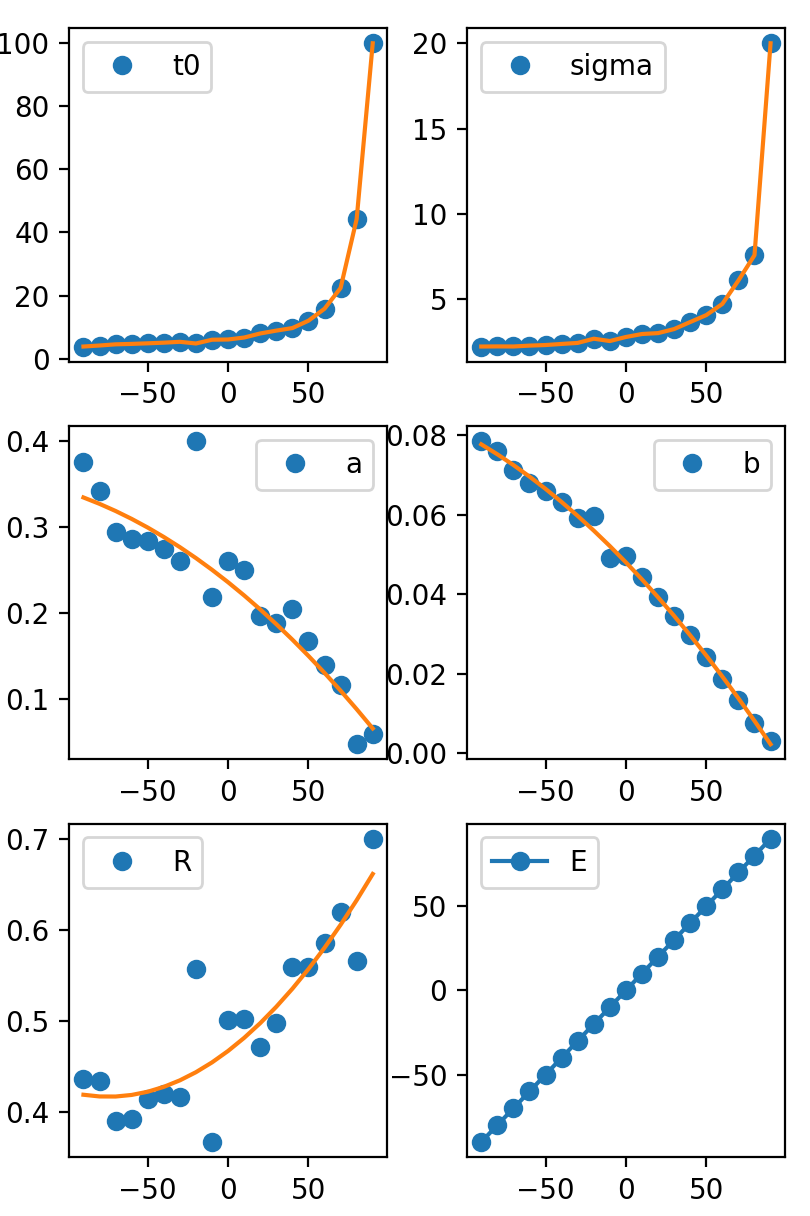

In [65]:
variables = 't0 sigma a b R'.split()
plt.figure(figsize=(6,8))

for i,v in enumerate(variables):
    plt.subplot(3, 2, i+1)
    x, y = E0s, get_p_list(v)
    plt.plot(x, y, 'o', label=v)
    # print v; break
    y2 = rpif_Ei_100.interped_funcs[v](x)
    plt.plot(x, y2)
    plt.legend()
    continue

plt.subplot(3, 2, 6)
plt.plot(E0s, E0s, '-o', label='E')
plt.legend()

plt.tight_layout()
plt.show()

Compare to sim data

<IPython.core.display.Javascript object>


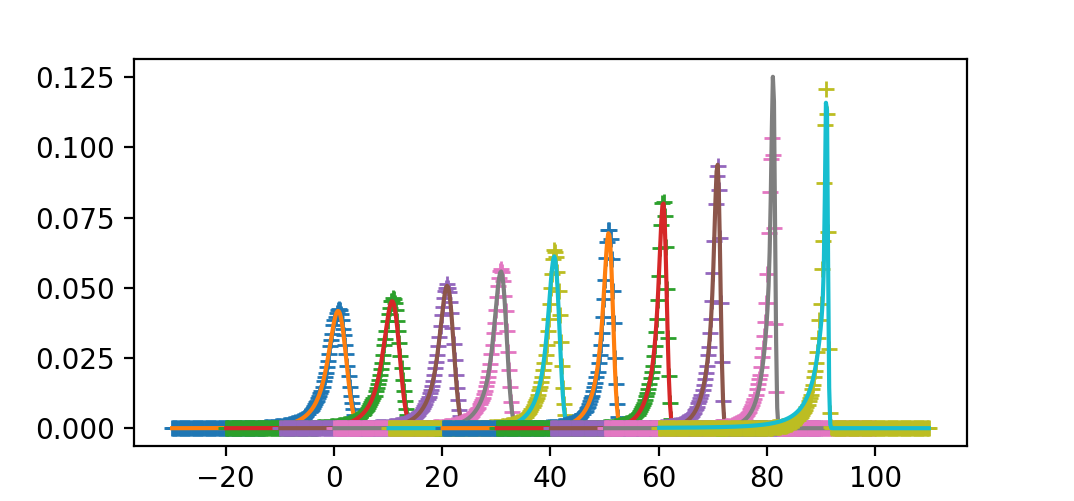

In [66]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(0., Ei, 10.):
    x,y0,y0err = fitIE.getData(Q, E0)
    params = dict()
    for name in rpif_Ei_100.interped_funcs.keys():
        value = rpif_Ei_100.interped_funcs[name](E0)
        params[name] = value
    y = icg.resolution(x, Ei=Ei, E0=E0, geom=geom, **params)
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x,y0, '+')
    plt.plot(x, y)
plt.show()

Try some Energy transfer values that were not simulated by mcvine

In [67]:
interped_funcs = rpif_Ei_100.interped_funcs

<IPython.core.display.Javascript object>


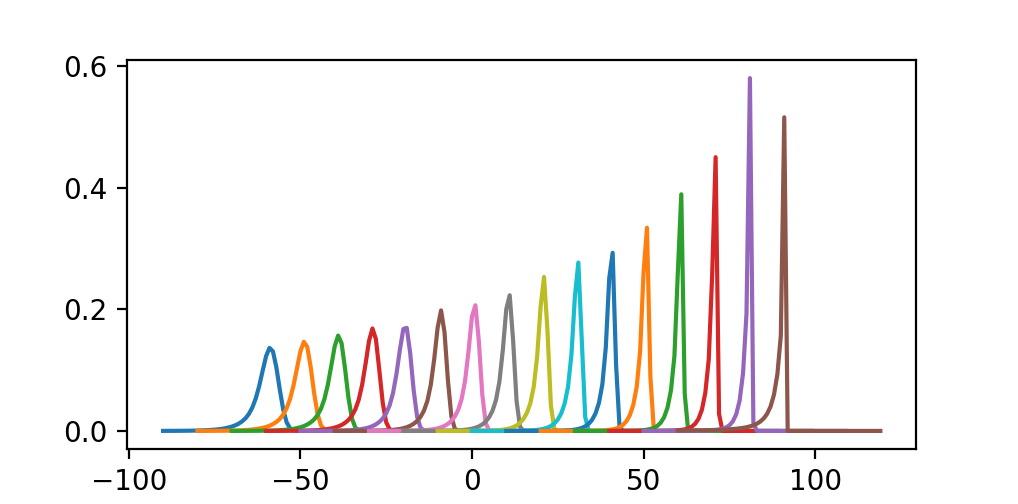

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/dgsres-0.0.1a1-py2.7.egg/dgsres/icg.py:31: RuntimeWarning: divide by zero encountered in divide
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/dgsres-0.0.1a1-py2.7.egg/dgsres/icg.py:51: RuntimeWarning: invalid value encountered in subtract
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/dgsres-0.0.1a1-py2.7.egg/dgsres/icg.py:55: RuntimeWarning: invalid value encountered in subtract
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/dgsres-0.0.1a1-py2.7.egg/dgsres/icg.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/dgsres-0.0.1a1-py2.7.egg/dgsres/icg.py:31: RuntimeWarning: invalid value encountered in add
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in 

In [68]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(-60., 128., 10.):
    params = dict()
    for name in interped_funcs.keys():
        value = interped_funcs[name](E0)
        params[name] = value
    x = np.arange(E0-30, E0+30, 1.)
    y = icg.resolution(x, Ei=Ei, E0=E0, geom=geom, **params)
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x, y)
plt.show()

It is not very good after 110meV